In [1]:
import glob
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.interpolate import interp1d
from scipy.stats.stats import pearsonr   
import itertools as it
import Colors
from neupy import algorithms

In [2]:
ls ../hG0*/*_spliced.coutt.tsv

../hG01-20umAP-120h-ChiSB43/mG01_trim_star_spliced.coutt.tsv
../hG02-20umAP-120h-ChiSB43/mG02_trim_star_spliced.coutt.tsv
../hG03-20umAP-72h-Chi/mG03_trim_star_spliced.coutt.tsv
../hG04-20umAP-72h-Chi/mG04_trim_star_spliced.coutt.tsv


# read data

In [3]:
fchisb = ['../hG01-20umAP-120h-ChiSB43/mG01_trim_star_spliced.coutt.tsv', '../hG02-20umAP-120h-ChiSB43/mG02_trim_star_spliced.coutt.tsv']
fchi = ['../hG03-20umAP-72h-Chi/mG03_trim_star_spliced.coutt.tsv', '../hG04-20umAP-72h-Chi/mG04_trim_star_spliced.coutt.tsv']

In [4]:
fchisb_u = ['../hG01-20umAP-120h-ChiSB43/mG01_trim_star_unspliced.coutt.tsv', '../hG02-20umAP-120h-ChiSB43/mG02_trim_star_unspliced.coutt.tsv']
fchi_u = ['../hG03-20umAP-72h-Chi/mG03_trim_star_unspliced.coutt.tsv', '../hG04-20umAP-72h-Chi/mG04_trim_star_unspliced.coutt.tsv']

In [5]:
csbdf = [read_csv(f, sep = '\t', index_col=0) for f in fchisb]
chidf = [read_csv(f, sep = '\t', index_col=0) for f in fchi]

In [6]:
csbdf_U = [read_csv(f, sep = '\t', index_col=0) for f in fchisb_u]
chidf_U = [read_csv(f, sep = '\t', index_col=0) for f in fchi_u]

# remove suspicious genes

In [7]:
def removeGenes(df):
    genes = ['ERCC', 'Kcnq1ot1', 'Mir5109', 'Lars2','Malat1', 'Rn45s', 'RPL', 'RPS','__MT']
    exclude = [idx for idx in df.index for g in genes if g in idx]
    return df.loc[[idx for idx in df.index if idx not in exclude]]

def removeGmGenes(df):
    alphabet = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    numbers = [str(i) for i in range(10)]
    gmhumangenes = []
    for idx in df.index:
        g = idx.rsplit('_')[1]
        if all([x in alphabet for x in g[:2]]) and all([x in numbers for x in g[2:-2]]) and g[-2]=='.' and g[-1] in numbers:
            gmhumangenes.append(idx)
    return df.loc[[idx for idx in df.index if idx not in gmhumangenes]]

In [8]:
def removePeakyGenes(df):
    genes = []
    for idx in df.index:
        if sum(df.loc[idx]/df.loc[idx].sum()>=0.9)>=1: # and df.loc[idx].sum()<20:
            genes.append(idx)
    return df.loc[[idx for idx in df.index if idx not in genes]] # genes

In [9]:
fcsbdfs = [removePeakyGenes(removeGmGenes(removeGenes(df))) for df in csbdf]
fchidfs = [removePeakyGenes(removeGmGenes(removeGenes(df))) for df in chidf]

In [10]:
fcsbdfs_U = [removeGmGenes(removeGenes(df)) for df in csbdf_U]
fchidfs_U = [removeGmGenes(removeGenes(df)) for df in chidf_U]

# normalization

In [11]:
nfdfchis = [df.sum().mean()*df/df.sum() for df in fchidfs]
nfdfcsbs = [df.sum().mean()*df/df.sum() for df in fcsbdfs]

In [12]:
nfdfchis_U = [df.sum().mean()*df/df.sum() for df in fchidfs_U]
nfdfcsbs_U = [df.sum().mean()*df/df.sum() for df in fcsbdfs_U]

# z-score

In [13]:
def zscore(df):
    df = df.loc[df.index[df.sum(axis=1)>0]]
    zdf = df.T
    zdf = (zdf-zdf.mean())/zdf.std()
    zdf = zdf.T
    return zdf

def scalezscore(zdf):
    df  = ((zdf.T>=0)*zdf.T/zdf.max(axis=1) + (zdf.T<0)*zdf.T/abs(zdf.min(axis=1))).T
    return df

In [14]:
znfdfchis = [zscore(df) for df in nfdfchis]
sznfdfchis = [scalezscore(df) for df in znfdfchis]

znfdfcsbs = [zscore(df) for df in nfdfcsbs]
sznfdfcsbs = [scalezscore(df) for df in znfdfcsbs]

In [15]:
znfdfchis_U = [zscore(df) for df in nfdfchis_U]
sznfdfchis_U = [scalezscore(df) for df in znfdfchis_U]

znfdfcsbs_U = [zscore(df) for df in nfdfcsbs_U]
sznfdfcsbs_U = [scalezscore(df) for df in znfdfcsbs_U]

# barplots for some genes

In [16]:
allgenes = set(list(znfdfchis[0].index) + list(znfdfchis[1].index))

In [17]:
nodeGenes = ['Nodal','Lefty1','Lefty2','Ptch1','Pitx2','Dll1','Foxa2','Noto','Notch1','Notch2','Cer1',
             'Aldh1a2','Chrd','Raldh2','Dand5']
somitoGenes = ['Meox1','Lfng','Mesp1','Mesp2','TBXT','Cdx2','Wnt3a','Tcf15']
endodermGenes = ['Tbx5','Fgf10','Raldh2','Hoxa1','Fgf8','Tbx1','Bmp2','Mef2c','Ednra','Nkx2-5','Mlc2a',
                 'Isl1','Hand1','Hand2','Sox2','Tbx20','Wnt11','Mef2c','Nkx2-1','Fgfr1','Fgfr4','Gata4',
                 'Gata6','Six2' ]

In [18]:
nodeGenes2 = []
for g in nodeGenes:
    k = [x for x in allgenes if '_' + g.upper() + '__' in x]
    if len(k)==1:
        nodeGenes2.append(k[0])
    else:
        print 'careful with ', g, k

careful with  Raldh2 []


In [19]:
somitoGenes2 = []
for g in somitoGenes:
    k = [x for x in allgenes if '_' + g.upper() + '__' in x]
    if len(k)==1:
        somitoGenes2.append(k[0])
    else:
        print 'careful with ', g, k

In [20]:
endodermGenes2 = []
for g in endodermGenes:
    k = [x for x in allgenes if '_' + g.upper() + '__' in x]
    if len(k)==1:
        endodermGenes2.append(k[0])
    else:
        print 'careful with ', g, k

careful with  Raldh2 []
careful with  Mlc2a []
careful with  Tbx20 []
careful with  Nkx2-1 []


In [21]:
def plotZscores(dfs, genes, ylabel  = 'z-score'):
    pattern = ['-','--']
    for j, df in enumerate(dfs):
        for i, g in enumerate(genes):
            if g in df.index:
                plt.plot(range(len(df.columns)), df.loc[g], linestyle = pattern[j], c = Colors.colors[i])
            else:
                plt.plot(range(len(df.columns)), [0 for c in df.columns], linestyle = pattern[j], c = Colors.colors[i])

    plt.legend([x.rsplit('_')[1] for x in genes], loc = 2, bbox_to_anchor = (1,1))
    plt.xlabel('sections')
    plt.ylabel(ylabel)
    return plt
#    plt.show()

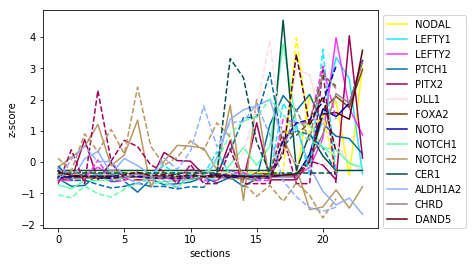

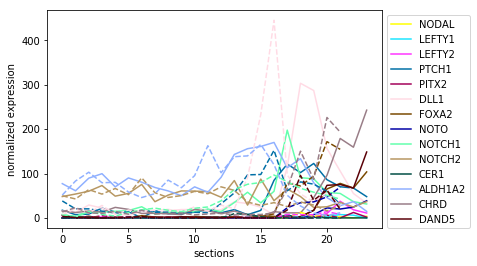

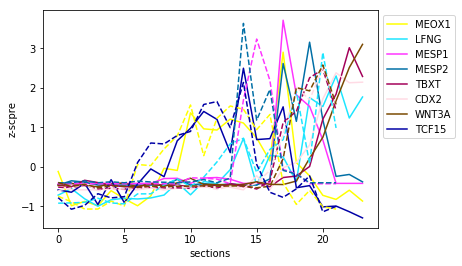

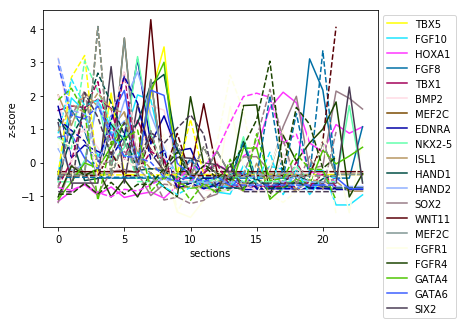

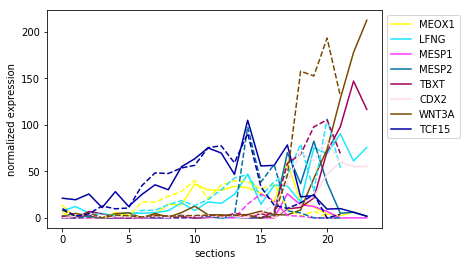

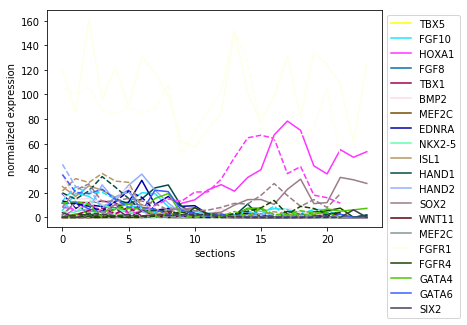

In [22]:
path = '/Users/anna/Dropbox/gastruloids/WritingPapers/code4figures/figHuman/'
plt = plotZscores(znfdfchis, nodeGenes2)
plt.savefig(path + 'zscore_nodeGenes.pdf')
plt.show()
plt = plotZscores(nfdfchis, nodeGenes2, 'normalized expression')
plt.savefig(path + 'nexpr_nodeGenes.pdf')
plt.show()
plt = plotZscores(znfdfchis, somitoGenes2, 'z-scpre')
plt.savefig(path + 'zscore_somitoGenes.pdf')
plt.show()
plt = plotZscores(znfdfchis, endodermGenes2, 'z-score')
plt.savefig(path + 'zscore_endodermGenes.pdf')
plt.show()
plt = plotZscores(nfdfchis, somitoGenes2, 'normalized expression')
plt.savefig(path + 'nexpr_somitoGenes.pdf')
plt.show()
plt = plotZscores(nfdfchis, endodermGenes2, 'normalized expression')
plt.savefig(path + 'nexpr_endodermGenes.pdf')
plt.show()

In [23]:
path = '/Users/anna/Dropbox/gastruloids/WritingPapers/code4figures/figHuman/'
znfdfchis[0].loc[nodeGenes2].to_csv(path + 'z-scores_nodeGenes_Chi1.tsv', sep = '\t')
znfdfchis[1].loc[nodeGenes2].to_csv(path + 'z-scores_nodeGenes_Chi2.tsv', sep = '\t')
znfdfchis[0].loc[somitoGenes2].to_csv(path + 'z-scores_somitoGenes_Chi1.tsv', sep = '\t')
znfdfchis[1].loc[somitoGenes2].to_csv(path + 'z-scores_somitoGenes_Chi2.tsv', sep = '\t')
znfdfchis[0].loc[endodermGenes2].to_csv(path + 'z-scores_endodermGenes_Chi1.tsv', sep = '\t')
znfdfchis[1].loc[endodermGenes2].to_csv(path + 'z-scores_endodermGenes_Chi2.tsv', sep = '\t')

In [24]:
path = '/Users/anna/Dropbox/gastruloids/WritingPapers/code4figures/figHuman/'
nfdfchis[0].loc[nodeGenes2].to_csv(path + 'nexpr_nodeGenes_Chi1.tsv', sep = '\t')
nfdfchis[1].loc[nodeGenes2].to_csv(path + 'nexpr_nodeGenes_Chi2.tsv', sep = '\t')
nfdfchis[0].loc[somitoGenes2].to_csv(path + 'nexpr_somitoGenes_Chi1.tsv', sep = '\t')
nfdfchis[1].loc[somitoGenes2].to_csv(path + 'nexpr_somitoGenes_Chi2.tsv', sep = '\t')
nfdfchis[0].loc[endodermGenes2].to_csv(path + 'nexpr_endodermGenes_Chi1.tsv', sep = '\t')
nfdfchis[1].loc[endodermGenes2].to_csv(path + 'nexpr_endodermGenes_Chi2.tsv', sep = '\t')

# gene correlation analysis

In [25]:
def geneCorrelation(df1, df2):
    x1 = 1.0*np.arange(len(df1.columns))/(len(df1.columns)-1)
    x2 = 1.0*np.arange(len(df2.columns))/(len(df2.columns)-1)
    cnt = Counter(list(df1.index) + list(df2.index))
    genes = [g for g in cnt if cnt[g] == 2]
    
    cdf = pd.Series(0, index = genes)
    for g in genes:
        idf2 = interp1d(x2, df2.loc[g].values, kind='quadratic')
        cdf.loc[g] = pearsonr(df1.loc[g], idf2(x1))[0]
    return cdf

In [26]:
def geneCorrelation_v(dfs):
    cdf = {i: {j: 0 for j in range(len(dfs))} for i in range(len(dfs))}
    for i1, i2 in it.combinations(range(len(dfs)),2):
        print i1, i2
        cdf[i1][i2] = geneCorrelation(dfs[i1], dfs[i2])
        cdf[i2][i1] = geneCorrelation(dfs[i2], dfs[i1])
    return cdf
    

In [27]:
cdfchi = geneCorrelation_v(znfdfchis)
cdfcsb = geneCorrelation_v(znfdfcsbs)

0 1
0 1


/Users/anna/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


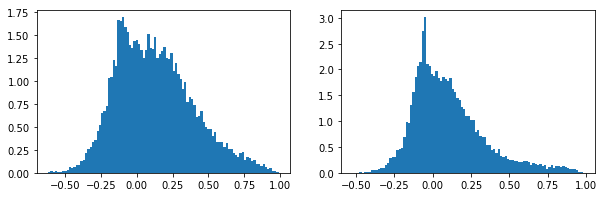

In [28]:
plt.figure(figsize=(10,3))

plt.subplot(121)
plt.hist(cdfchi[0][1], bins = 100, normed=True)
plt.subplot(122)
plt.hist(cdfcsb[0][1], bins = 100, normed=True)

plt.show()

# background model

In [29]:
def simulationCorrelations(n1, n2, N = 1000, ths = [0.05,0.01,0.005,0.001], seed = 123456):
    x1 = np.linspace(0,1,n1)
    x2 = np.linspace(0,1,n2)
    ps = [0 for i in range(N)]
    np.random.seed(seed)
    for i in range(N):
        d1 = np.random.rand(n1)
        d2 = np.random.rand(n2)

        id2 = interp1d(x2, d2, kind='quadratic')
        ps[i] = pearsonr(d1, id2(x1))[0]
    hist = np.histogram(ps, bins = 100, normed=True)
    hdf = pd.DataFrame({'prob': hist[0], 'corr': [hist[1][i:i+2].mean() for i in range(len(hist[0]))]})
    dx = hdf.loc[1,'corr']-hdf.loc[0,'corr']
    hdf['cum'] = hdf['prob'].cumsum()*dx
    canti = {th: hdf.loc[hdf[hdf['cum']<=th].index[-1], 'corr'] for th in ths}
    ccorr = {th: hdf.loc[hdf[hdf['cum']>=1-th].index[0], 'corr'] for th in ths}
    return ps, canti, ccorr

In [30]:
# particular case gastruloid 1 versus gastruloid 2
pschi, cantichi, ccorrchi = simulationCorrelations(len(znfdfchis[0].columns), len(znfdfchis[1].columns), N = 5000, ths = [0.05,0.01,0.005,0.001], seed = 125671)
pscsb, canticsb, ccorrcsb = simulationCorrelations(len(znfdfcsbs[0].columns), len(znfdfcsbs[1].columns), N = 5000, ths = [0.05,0.01,0.005,0.001], seed = 578019)

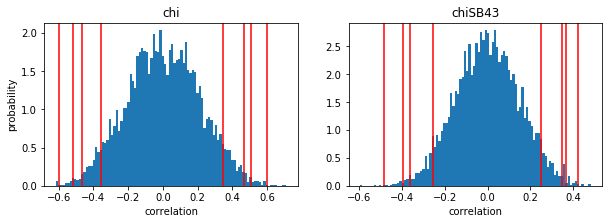

In [31]:
plt.figure(figsize=(10,3))
plt.subplot(121)
plt.hist(pschi, bins = 100, normed=True)
for pv in cantichi:
    plt.axvline(cantichi[pv], c= 'r')
    plt.axvline(ccorrchi[pv], c= 'r')
plt.title('chi')
plt.xlabel('correlation')
plt.ylabel('probability')

plt.subplot(122)
plt.hist(pscsb, bins = 100, normed=True)
for pv in canticsb:
    plt.axvline(canticsb[pv], c= 'r')
    plt.axvline(ccorrcsb[pv], c= 'r')
plt.title('chiSB43')
plt.xlabel('correlation')
plt.show()

# gene selection

In [32]:
def corrGenes_pairs(znfdfs, cdf, pvals = [0.05, 0.01, 0.001], seed = 3723641):
    corrGenesdf = {pv: {i: {j: [] for j in range(len(znfdfs))} for i in range(len(znfdfs))} for pv in pvals}
    np.random.seed(seed)
    for i1, i2 in it.combinations(range(len(znfdfs)),2):
        print i1, i2
        for pv in pvals:
            ps, ca, cc = simulationCorrelations(len(znfdfs[i1].columns), len(znfdfs[i2].columns), N = 10000, ths = [pv])
            corrGenesdf[pv][i1][i2] = list(cdf[i1][i2][cdf[i1][i2] > cc[pv]].index)
            ps, ca, cc = simulationCorrelations(len(znfdfs[i2].columns), len(znfdfs[i1].columns), N = 10000, ths = [pv])
            corrGenesdf[pv][i2][i1] = list(cdf[i2][i1][cdf[i2][i1] > cc[pv]].index)        
    return corrGenesdf

In [33]:
corrGenesdfchi = corrGenes_pairs(znfdfchis, cdfchi, pvals = [0.05, 0.01, 0.005, 0.001], seed = 866253)
corrGenesdfcsb = corrGenes_pairs(znfdfcsbs, cdfcsb, pvals = [0.05, 0.01, 0.005, 0.001], seed = 715385)

0 1
0 1


In [34]:
def selectGenes(znfdfs, corrGenesdf):
    i1 = 0; i2 = 1
    corrgenes = pd.Series([g for g in list(set(corrGenesdf[i1][i2] + corrGenesdf[i2][i1]))])
    return corrgenes

In [35]:
corrGenespvchi = {pv: selectGenes(znfdfchis, corrGenesdfchi[pv]) for pv in corrGenesdfchi}
corrGenespvcsb = {pv: selectGenes(znfdfcsbs, corrGenesdfcsb[pv]) for pv in corrGenesdfcsb}

In [36]:
{pv: len(corrGenespvchi[pv]) for pv in corrGenespvchi}

{0.001: 1023, 0.005: 1439, 0.01: 1817, 0.05: 3212}

# SOM cluster

In [37]:
def SOMclustering(df, gridheight = 10, gridwidth = 10):
    GRID_HEIGHT = gridheight
    GRID_WIDTH = gridwidth
    somfun = algorithms.SOFM(
            n_inputs=len(df.columns),
            features_grid=(GRID_HEIGHT, GRID_WIDTH),
            learning_radius=4,
            reduce_radius_after=50,
            step=0.5,
            std=1,
            shuffle_data=True,
            verbose=False)
    somfun.train(np.array(df), epochs = 300)
    clustersr = somfun.predict(np.array(df)).argmax(axis=1)
    cl_genelist_df = pd.Series(clustersr, index = df.index)
    return cl_genelist_df

In [38]:
def mergedfs(dfs):
    for i in range(len(dfs)):
        dfs[i].columns = [c +'-rep' + str(i+1) for c in dfs[i].columns]
    mdf = dfs[0]
    for df in dfs[1:]:
        mdf = mdf.merge(df, how = 'outer', left_index = True, right_index = True)
        mdf = mdf.fillna(0)
    return mdf

In [39]:
def getClusterByColor(dg, labels):
    kk = []
    ii = 0
    cluster = 0
    color = dg['color_list'][0]
    clusters = {cluster: []}
    for i in range(len(dg['icoord'])):
        v = dg['icoord'][i]
        for j in [0,2]:
            vj = int(round((v[j]-5.)/10))
            if (v[j]-5.)/10 == vj and vj not in kk:
                kk.append(vj)
                if dg['color_list'][i] == color:
                    clusters[cluster].append(labels[dg['leaves'][vj]])
                else:
                    color = dg['color_list'][i]
                    cluster += 1
                    clusters[cluster] = [labels[dg['leaves'][vj]]]
    return clusters

In [40]:
mznfdfchis = mergedfs(znfdfchis)
mznfdfcsbs = mergedfs(znfdfcsbs)

In [41]:
somcl_chi_df = SOMclustering(mznfdfchis.loc[corrGenespvchi[0.001]])
somcl_csb_df = SOMclustering(mznfdfcsbs.loc[corrGenespvcsb[0.001]])

In [42]:
print Counter(somcl_chi_df).most_common(5), Counter(somcl_chi_df).most_common()[-5:]
print Counter(somcl_csb_df).most_common(5), Counter(somcl_csb_df).most_common()[-5:]

[(38, 32), (82, 28), (13, 24), (37, 24), (28, 22)] [(86, 3), (95, 3), (65, 2), (66, 2), (87, 2)]
[(65, 71), (12, 51), (70, 45), (77, 40), (67, 39)] [(64, 3), (79, 3), (44, 2), (53, 2), (78, 2)]


In [43]:
mudfchi = pd.DataFrame({i: mznfdfchis.loc[somcl_chi_df[somcl_chi_df==i].index].mean() for i in set(somcl_chi_df) })
mudfcbs = pd.DataFrame({i: mznfdfcsbs.loc[somcl_csb_df[somcl_csb_df==i].index].mean() for i in set(somcl_csb_df) })

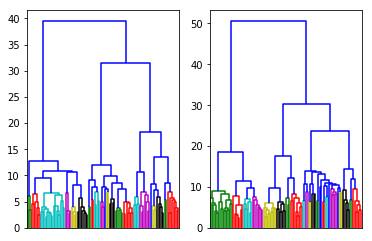

In [44]:
hclsomchi = linkage(mudfchi.T, method='ward', metric='euclidean')
hclsomcbs = linkage(mudfcbs.T, method='ward', metric='euclidean')
plt.subplot(121)
dgchi = dendrogram(hclsomchi, no_labels=True, color_threshold = 7) # 5
plt.subplot(122)
dgcbs = dendrogram(hclsomcbs, no_labels=True, color_threshold = 9.5) # 5
plt.show()

In [45]:
hcldicchi = getClusterByColor(dgchi, mudfchi.columns)
hcldiccbs = getClusterByColor(dgcbs, mudfcbs.columns)

In [46]:
somcl_chi_df = pd.DataFrame(somcl_chi_df, columns=['som'])
somcl_chi_df['hcl'] = [k for s in somcl_chi_df['som'] for k in hcldicchi.keys() if s in hcldicchi[k]]

In [47]:
somcl_csb_df = pd.DataFrame(somcl_csb_df, columns=['som'])
somcl_csb_df['hcl'] = [k for s in somcl_csb_df['som'] for k in hcldiccbs.keys() if s in hcldiccbs[k]]

In [48]:
# path = '/Users/anna/Dropbox/gastruloids/WritingPapers/code4figures/figHuman/'
# somcl_csb_df.to_csv(path + 'som_hcl_ChiSB.txt', sep = '\t')
# somcl_chi_df.to_csv(path + 'som_hcl_Chi.txt', sep = '\t')

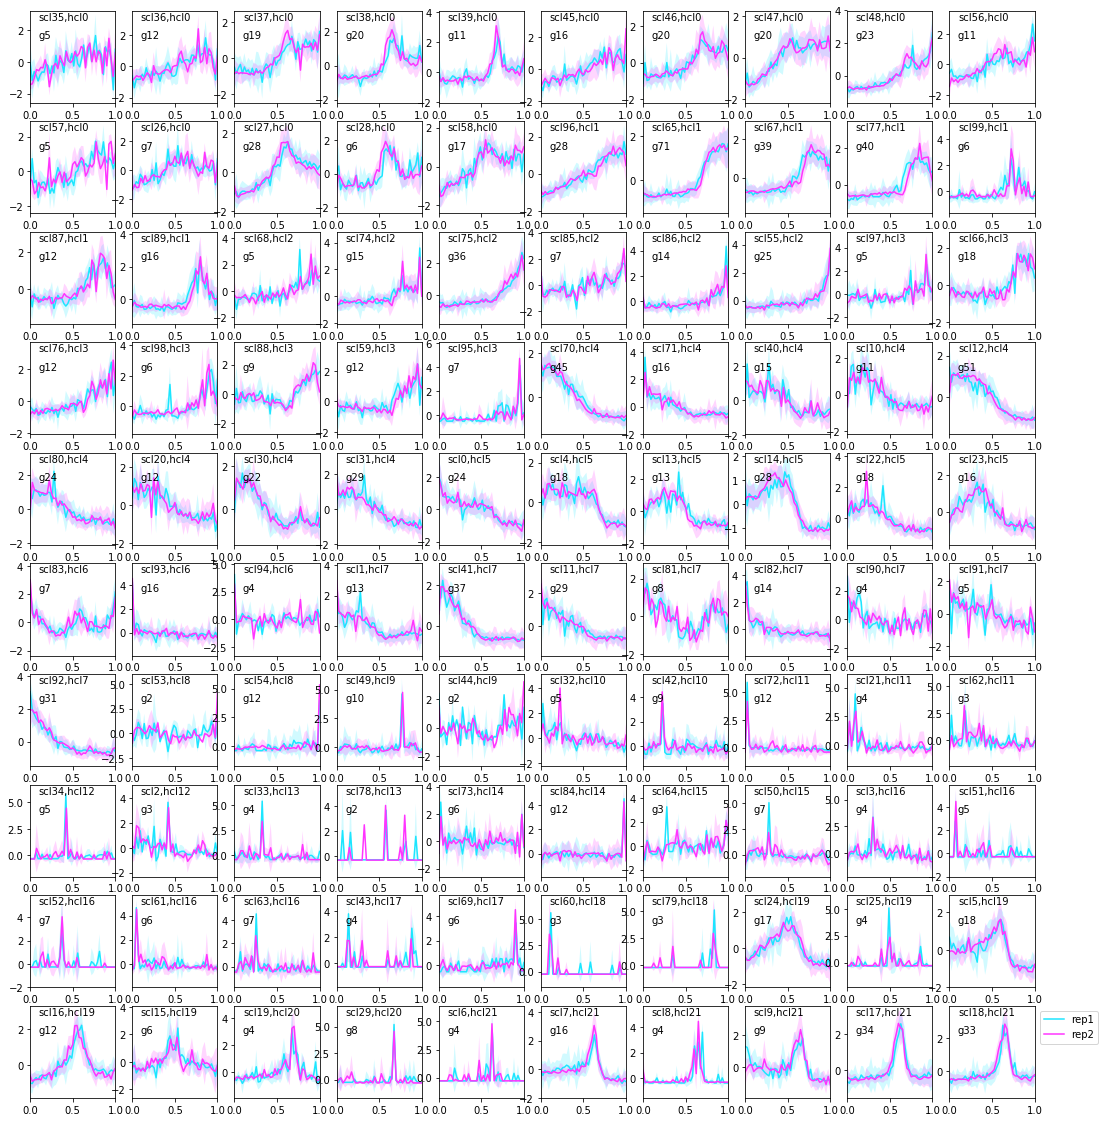

In [49]:
j = 0
fig = plt.figure(figsize=(18,20))
for hcl in set(somcl_csb_df['hcl']):
    for cl in set(somcl_csb_df[somcl_csb_df['hcl']==hcl]['som']):
        j += 1
        ax = fig.add_subplot(10,10,j)
        genes = somcl_csb_df[somcl_csb_df['som']==cl].index
        for i, df in enumerate(znfdfcsbs):
            xra = 1.0*np.arange(len(df.columns))/(len(df.columns)-1)
            mu = df.loc[genes].mean()
            mup = mu + df.loc[genes].std()
            mum = mu - df.loc[genes].std()
            ax.plot(xra, mu, c = Colors.colors[i+1])
            ax.fill_between(xra, mup, mum, facecolor=Colors.colors[i+1], interpolate=True, alpha = 0.2)
        title1 = 'scl' + str(cl) + ',hcl' + str(hcl) 
        ax.text(0.1,.9, title1, horizontalalignment='left', transform=ax.transAxes)
        title2 = 'g' + str(len(genes)) 
        ax.text(0.1,.7, title2, horizontalalignment='left', transform=ax.transAxes)
        
        plt.xlim(0,1)
plt.legend(['rep1', 'rep2'], loc = 2, bbox_to_anchor = (1,1))

#plt.savefig(path+'/geneexpr_SOM_ChiSB43.pdf', bbox_inches = 'tight')
plt.show()

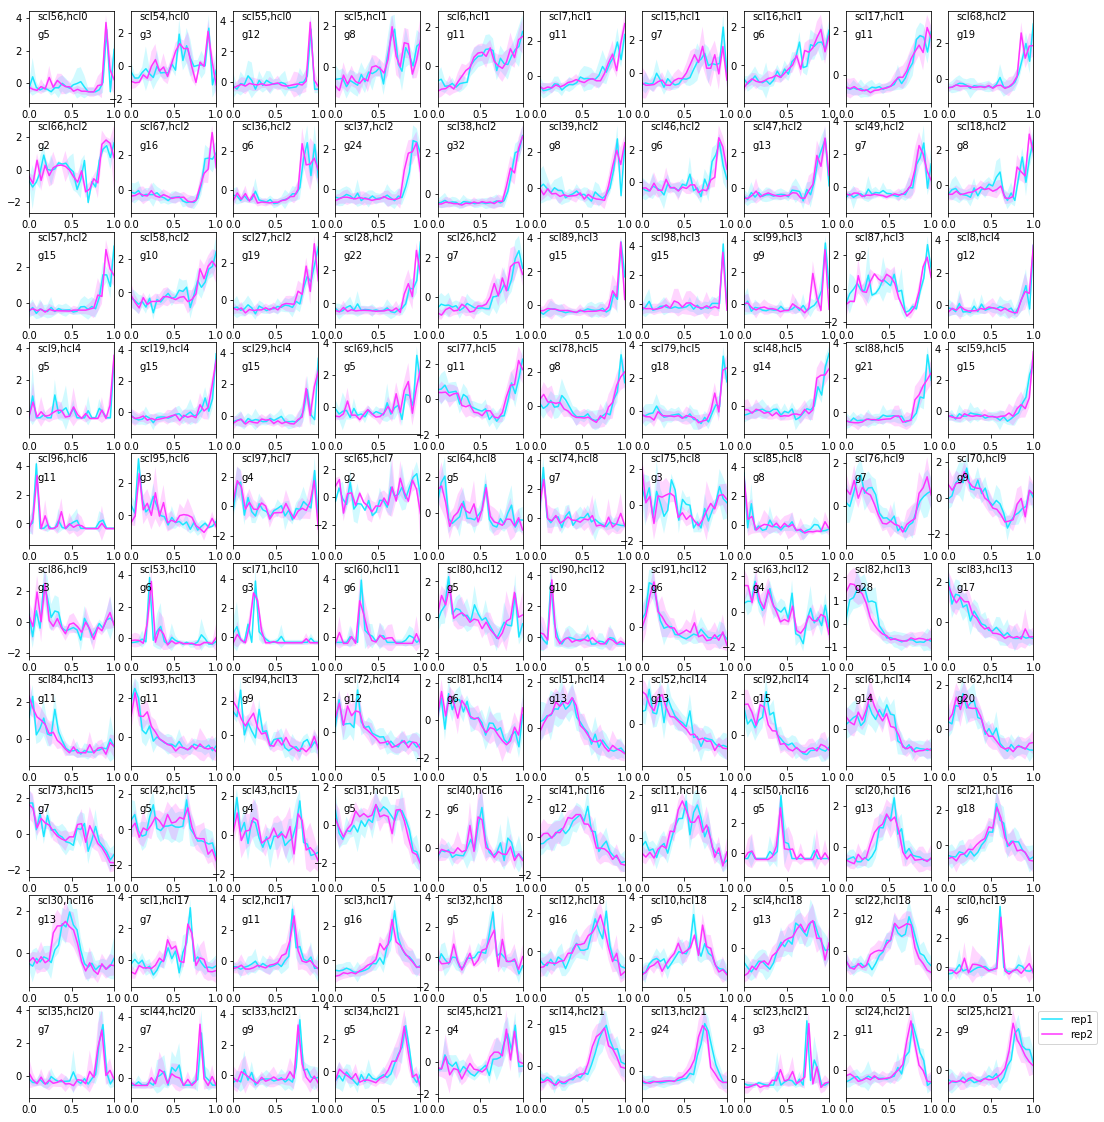

In [50]:
j = 0
fig = plt.figure(figsize=(18,20))
for hcl in set(somcl_chi_df['hcl']):
    for cl in set(somcl_chi_df[somcl_chi_df['hcl']==hcl]['som']):
        j += 1
        ax = fig.add_subplot(10,10,j)
        genes = somcl_chi_df[somcl_chi_df['som']==cl].index
        for i, df in enumerate(znfdfchis):
            xra = 1.0*np.arange(len(df.columns))/(len(df.columns)-1)
            mu = df.loc[genes].mean()
            mup = mu + df.loc[genes].std()
            mum = mu - df.loc[genes].std()
            ax.plot(xra, mu, c = Colors.colors[i+1])
            ax.fill_between(xra, mup, mum, facecolor=Colors.colors[i+1], interpolate=True, alpha = 0.2)
        title1 = 'scl' + str(cl) + ',hcl' + str(hcl) 
        ax.text(0.1,.9, title1, horizontalalignment='left', transform=ax.transAxes)
        title2 = 'g' + str(len(genes)) 
        ax.text(0.1,.7, title2, horizontalalignment='left', transform=ax.transAxes)
        
        plt.xlim(0,1)
plt.legend(['rep1', 'rep2'], loc = 2, bbox_to_anchor = (1,1))

#plt.savefig(path+'/geneexpr_SOM_Chi.pdf', bbox_inches = 'tight')
plt.show()

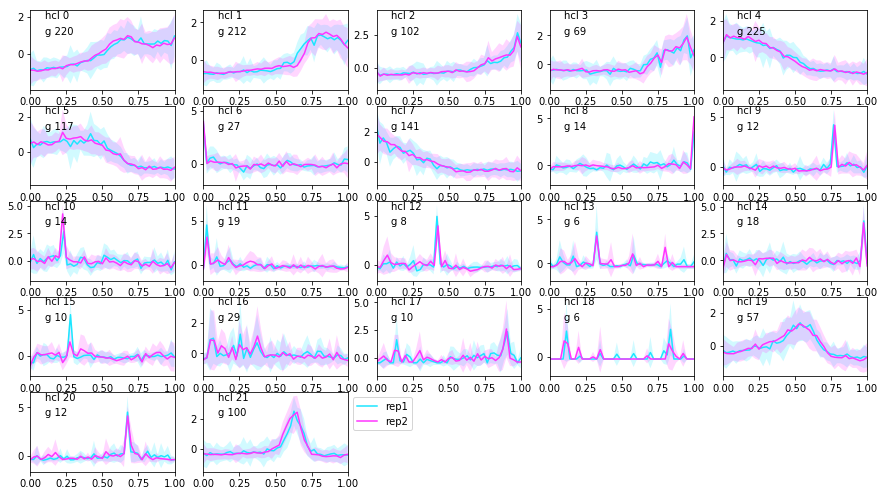

In [51]:
fig = plt.figure(figsize=(15,12))
k = 0
for cl in set(somcl_csb_df['hcl']):
    k += 1
    ax = fig.add_subplot(7,5,k)
    genes = somcl_csb_df[somcl_csb_df['hcl']==cl].index
    for i, df in enumerate(znfdfcsbs):
        xra = 1.0*np.arange(len(df.columns))/(len(df.columns)-1)
        mu = df.loc[genes].mean()
        mup = mu + df.loc[genes].std()
        mum = mu - df.loc[genes].std()
       
        ax.plot(xra, mu, c = Colors.colors[i+1])
        ax.fill_between(xra, mup, mum, facecolor=Colors.colors[i+1], interpolate=True, alpha = 0.2)
    title1 = 'hcl ' + str(cl) 
    title2 = 'g ' + str(len(genes))      
     
    ax.text(0.1,.9, title1, horizontalalignment='left', transform=ax.transAxes)
    ax.text(0.1,.7, title2, horizontalalignment='left', transform=ax.transAxes)
    
    plt.xlim(0,1)
plt.legend(['rep1', 'rep2'], loc = 2, bbox_to_anchor = (1,1))
#plt.savefig(path+'/geneexpr_hcl_ChiSB43.pdf', bbox_inches = 'tight')
plt.show()

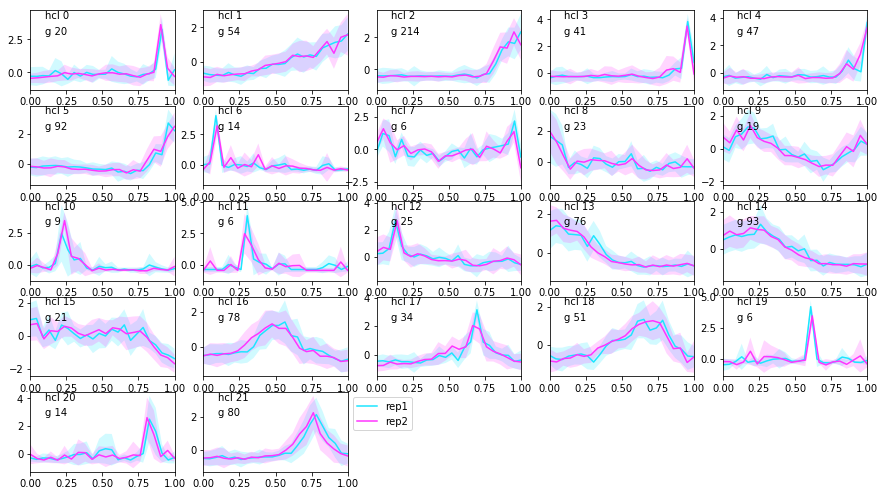

In [52]:
fig = plt.figure(figsize=(15,12))
k = 0
for cl in set(somcl_chi_df['hcl']):
    k += 1
    ax = fig.add_subplot(7,5,k)
    genes = somcl_chi_df[somcl_chi_df['hcl']==cl].index
    for i, df in enumerate(znfdfchis):
        xra = 1.0*np.arange(len(df.columns))/(len(df.columns)-1)
        mu = df.loc[genes].mean()
        mup = mu + df.loc[genes].std()
        mum = mu - df.loc[genes].std()
       
        ax.plot(xra, mu, c = Colors.colors[i+1])
        ax.fill_between(xra, mup, mum, facecolor=Colors.colors[i+1], interpolate=True, alpha = 0.2)
    title1 = 'hcl ' + str(cl) 
    title2 = 'g ' + str(len(genes))      
     
    ax.text(0.1,.9, title1, horizontalalignment='left', transform=ax.transAxes)
    ax.text(0.1,.7, title2, horizontalalignment='left', transform=ax.transAxes)
    
    plt.xlim(0,1)
plt.legend(['rep1', 'rep2'], loc = 2, bbox_to_anchor = (1,1))
#plt.savefig(path+'/geneexpr_hcl_Chi.pdf', bbox_inches = 'tight')
plt.show()

In [53]:
annotate = ['TBXT','NODAL','CDX2','RSPO3','SOX1','SOX2','WNT3a','FGF8','UNCX','TCF15','ALDH1A2',
            'MESP1','MESP2','RIPPLY2','DPPA5','GATA6','MEOX1','TBX6','CYP26A1','GATA4','HAND1','TBX1','PAX6',
            'ZEB2']

/Users/anna/anaconda/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


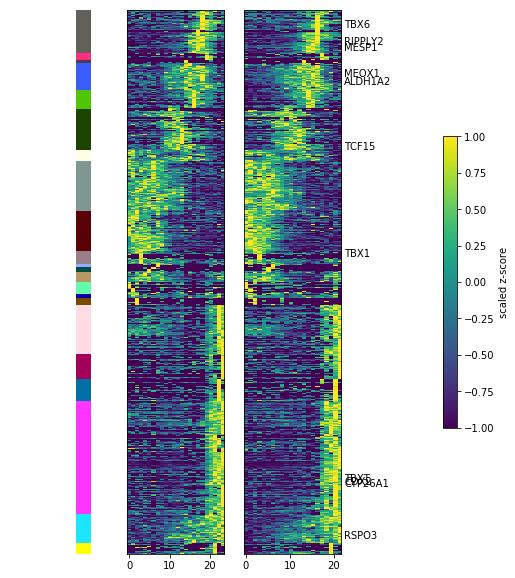

In [54]:
plt.figure(figsize=(8,10))

gene_order = somcl_chi_df.sort_values(by=['hcl','som']).index

plt.subplot(1,4,1, frameon = False)
y0 = 0; z0 = 0; xb = 4 # 3
for i in set(somcl_chi_df['hcl']):
    y = 1.0*somcl_chi_df[somcl_chi_df['hcl'] == i].shape[0]/somcl_chi_df.shape[0]
    plt.bar([xb], [y], bottom = y0, width = 0.3, color = Colors.colors[i])
    y0 += y       
plt.yticks([]); plt.xticks([])
plt.ylim(0,1)
plt.xlim(2.5,4.5)

for i, df in enumerate(znfdfchis):
    plt.subplot(1,4,i+2)
    plt.imshow(scalezscore(df.loc[gene_order][::-1]), aspect = 'auto')
    plt.yticks([])
plt.tick_params(axis='y', labelleft='off', labelright='on', length = 0)
plt.yticks(range(len(gene_order)), [g.rsplit('__')[0].rsplit('_')[-1] if g.rsplit('__')[0].rsplit('_')[-1] in annotate else '' for g in gene_order[::-1]])

plt.subplot(1,4, 4, frameon = False)
plt.xticks([]); plt.yticks([])
plt.colorbar(label = 'scaled z-score')

#plt.savefig(path+'/heatmap_Chi_hSOM.pdf', bbox_inches = 'tight')
plt.show()

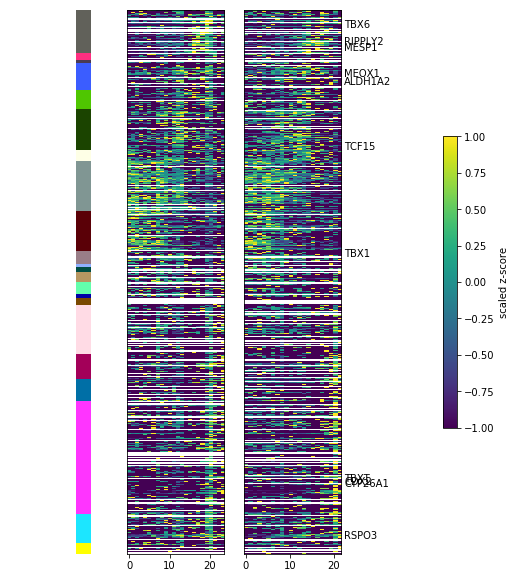

In [55]:
plt.figure(figsize=(8,10))

gene_order = somcl_chi_df.sort_values(by=['hcl','som']).index

plt.subplot(1,4,1, frameon = False)
y0 = 0; z0 = 0; xb = 4 # 3
for i in set(somcl_chi_df['hcl']):
    y = 1.0*somcl_chi_df[somcl_chi_df['hcl'] == i].shape[0]/somcl_chi_df.shape[0]
    plt.bar([xb], [y], bottom = y0, width = 0.3, color = Colors.colors[i])
    y0 += y       
plt.yticks([]); plt.xticks([])
plt.ylim(0,1)
plt.xlim(2.5,4.5)

for i, df in enumerate(znfdfchis_U):
    plt.subplot(1,4,i+2)
    plt.imshow(scalezscore(df.loc[gene_order][::-1]), aspect = 'auto')
    plt.yticks([])
plt.tick_params(axis='y', labelleft='off', labelright='on', length = 0)
plt.yticks(range(len(gene_order)), [g.rsplit('__')[0].rsplit('_')[-1] if g.rsplit('__')[0].rsplit('_')[-1] in annotate else '' for g in gene_order[::-1]])

plt.subplot(1,4, 4, frameon = False)
plt.xticks([]); plt.yticks([])
plt.colorbar(label = 'scaled z-score')

plt.savefig(path+'/heatmap_Chi_hSOM_unspliced.pdf', bbox_inches = 'tight')
plt.show()

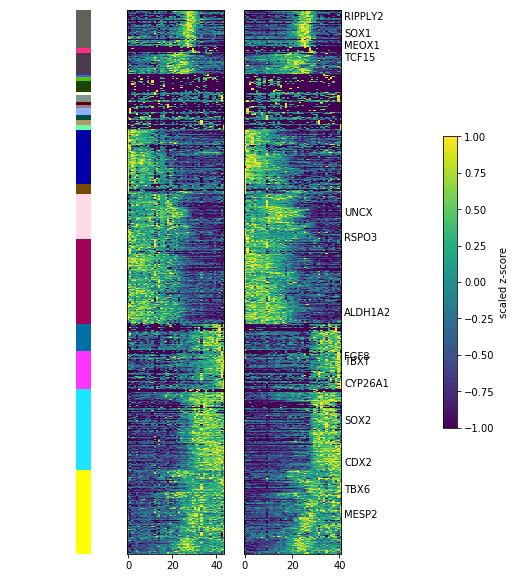

In [56]:
plt.figure(figsize=(8,10))

gene_order = somcl_csb_df.sort_values(by=['hcl','som']).index

plt.subplot(1,4,1, frameon = False)
y0 = 0; z0 = 0; xb = 4 # 3
for i in set(somcl_csb_df['hcl']):
    y = 1.0*somcl_csb_df[somcl_csb_df['hcl'] == i].shape[0]/somcl_csb_df.shape[0]
    plt.bar([xb], [y], bottom = y0, width = 0.3, color = Colors.colors[i])
    y0 += y       
plt.yticks([]); plt.xticks([])
plt.ylim(0,1)
plt.xlim(2.5,4.5)

for i, df in enumerate(znfdfcsbs):
    plt.subplot(1,4,i+2)
    plt.imshow(scalezscore(df.loc[gene_order][::-1]), aspect = 'auto')
    plt.yticks([])
plt.tick_params(axis='y', labelleft='off', labelright='on', length = 0)
plt.yticks(range(len(gene_order)), [g.rsplit('__')[0].rsplit('_')[-1] if g.rsplit('__')[0].rsplit('_')[-1] in annotate else '' for g in gene_order[::-1]])

plt.subplot(1,4, 4, frameon = False)
plt.xticks([]); plt.yticks([])
plt.colorbar(label = 'scaled z-score')

plt.savefig(path+'/heatmap_ChiSB43_hSOM.pdf', bbox_inches = 'tight')
plt.show()

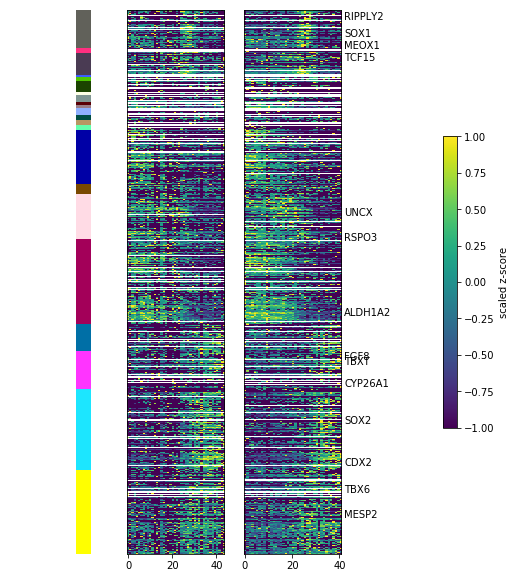

In [57]:
plt.figure(figsize=(8,10))

gene_order = somcl_csb_df.sort_values(by=['hcl','som']).index

plt.subplot(1,4,1, frameon = False)
y0 = 0; z0 = 0; xb = 4 # 3
for i in set(somcl_csb_df['hcl']):
    y = 1.0*somcl_csb_df[somcl_csb_df['hcl'] == i].shape[0]/somcl_csb_df.shape[0]
    plt.bar([xb], [y], bottom = y0, width = 0.3, color = Colors.colors[i])
    y0 += y       
plt.yticks([]); plt.xticks([])
plt.ylim(0,1)
plt.xlim(2.5,4.5)

for i, df in enumerate(znfdfcsbs_U):
    plt.subplot(1,4,i+2)
    plt.imshow(scalezscore(df.loc[gene_order][::-1]), aspect = 'auto')
    plt.yticks([])
plt.tick_params(axis='y', labelleft='off', labelright='on', length = 0)
plt.yticks(range(len(gene_order)), [g.rsplit('__')[0].rsplit('_')[-1] if g.rsplit('__')[0].rsplit('_')[-1] in annotate else '' for g in gene_order[::-1]])

plt.subplot(1,4, 4, frameon = False)
plt.xticks([]); plt.yticks([])
plt.colorbar(label = 'scaled z-score')

plt.savefig(path+'/heatmap_ChiSB43_hSOM_unspliced.pdf', bbox_inches = 'tight')
plt.show()

# Average gastruloids

In [58]:
def weightedAverage(df):
    cnt = Counter({g: 0 for g in set(idx.rsplit('-')[-1] for idx in df.index)})
    m = [0 for c in df.columns]
    for g in cnt.keys():
        g_idxs = [idx for idx in df.index if g in idx]
        m += df.loc[g_idxs].mean()*len(g_idxs)
    m = m/len(df)
    return m

def runningWeightedAverage(mdf):
    i0 = 0
    i = 0
    j = 0
    cnt = Counter({g: 0 for g in set(idx.rsplit('-')[-1] for idx in mdf.index)})
    xdf = pd.DataFrame(columns = mdf.columns)
    while i < len(mdf.index):
        g = mdf.index[i].rsplit('-')[-1]
        cnt.update([g])
        if all([cnt[g]>0 for g in cnt]):
#            xdf.loc[j] = mdf.iloc[i0:i].mean()
            xdf.loc[j] = weightedAverage(mdf.iloc[i0:i])
            cnt = Counter({g: 0 for g in set(idx.rsplit('-')[-1] for idx in mdf.index)})
            j += 1
            i0 = i
        i += 1
    xdf.loc[j] = mdf.iloc[i0:i].mean()
    return xdf

In [59]:
def averageGastruloid(znfdfs, mznfdfs):
    mdf = mznfdfs.T
    d = {}
    for df in znfdfs:
        xra = 1.0*np.arange(len(df.columns))/(len(df.columns)-1)
        for i, c in enumerate(df.columns):
            d[c] = xra[i]
    mdf['x'] = [d[idx] for idx in mdf.index]
    mdf = mdf.sort_values(by = 'x', ascending=True)
    xdf = runningWeightedAverage(mdf)
    xdf = xdf.T
    return xdf

In [60]:
avchidf = averageGastruloid(znfdfchis, mznfdfchis)
avcsbdf = averageGastruloid(znfdfcsbs, mznfdfcsbs)

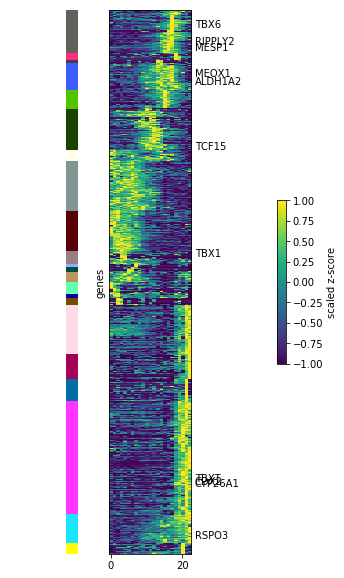

In [61]:
plt.figure(figsize=(5,10))

gene_order = somcl_chi_df.sort_values(by=['hcl','som']).index

plt.subplot(1,3,1, frameon = False)
y0 = 0; z0 = 0
for i in set(somcl_chi_df['hcl']):
    y = 1.0*somcl_chi_df[somcl_chi_df['hcl'] == i].shape[0]/somcl_chi_df.shape[0]
    plt.bar([3.5], [y], bottom = y0, width = 0.3, color = Colors.colors[i])
    y0 += y  

plt.yticks([]); plt.xticks([])
plt.ylim(0,1)
plt.xlim(2,4)

plt.subplot(1,3,2)
plt.imshow(scalezscore(avchidf.loc[gene_order[::-1]]), aspect='auto')
plt.tick_params(axis='y', labelleft='off', labelright='on', length = 0)
plt.yticks(range(len(gene_order)), [g.rsplit('__')[0].rsplit('_')[-1] if g.rsplit('__')[0].rsplit('_')[-1] in annotate else '' for g in gene_order[::-1]])
plt.ylabel('genes')

plt.subplot(1,3,3, frameon = False)
plt.colorbar(label = 'scaled z-score', shrink = 0.3)
plt.xticks([])
plt.yticks([])

plt.savefig(path + '/heatmap_average_Chi.pdf', bbox_inches ='tight')

plt.show()

In [62]:
#avchidf.loc[gene_order[::-1]].to_csv(path + '/heatmap_average_Chi.txt', sep = '\t')
avchidf.to_csv(path + '/heatmap_average_Chi.txt', sep = '\t')

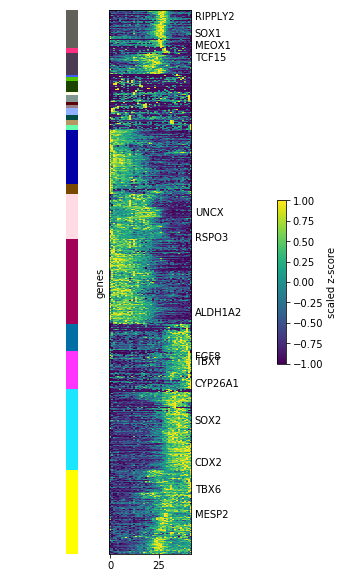

In [63]:
plt.figure(figsize=(5,10))

gene_order = somcl_csb_df.sort_values(by=['hcl','som']).index

plt.subplot(1,3,1, frameon = False)
y0 = 0; z0 = 0
for i in set(somcl_csb_df['hcl']):
    y = 1.0*somcl_csb_df[somcl_csb_df['hcl'] == i].shape[0]/somcl_csb_df.shape[0]
    plt.bar([3.5], [y], bottom = y0, width = 0.3, color = Colors.colors[i])
    y0 += y  

plt.yticks([]); plt.xticks([])
plt.ylim(0,1)
plt.xlim(2,4)

plt.subplot(1,3,2)
plt.imshow(scalezscore(avcsbdf.loc[gene_order[::-1]]), aspect='auto')
plt.tick_params(axis='y', labelleft='off', labelright='on', length = 0)
plt.yticks(range(len(gene_order)), [g.rsplit('__')[0].rsplit('_')[-1] if g.rsplit('__')[0].rsplit('_')[-1] in annotate else '' for g in gene_order[::-1]])
plt.ylabel('genes')

plt.subplot(1,3,3, frameon = False)
plt.colorbar(label = 'scaled z-score', shrink = 0.3)
plt.xticks([])
plt.yticks([])

plt.savefig(path + '/heatmap_average_ChiSB43.pdf', bbox_inches ='tight')

plt.show()

In [64]:
#avcsbdf.loc[gene_order[::-1]].to_csv(path + '/heatmap_average_ChiSB43.txt', sep = '\t')
avcsbdf.to_csv(path + '/heatmap_average_ChiSB43.txt', sep = '\t')

# somitogenesis genes

In [65]:
g_somito_mouse = ['Fgf8', 'Wnt3a', 'T', 'Tbx6','Dll1', 'Lfng', 'Mesp2', 'Ripply2', 'Notch1', 'Aldh1a2', 'Uncx', 'Meox1','Tcf15']

In [66]:
human2mouse = read_csv('../../human-mouse-orthologous.txt.gz', sep = '\t')

In [67]:
human2mouse.head()

,Gene stable ID,Transcript stable ID,Mouse gene stable ID,Mouse gene name,Mouse chromosome/scaffold name,Chromosome/scaffold name,Gene name
0,ENSG00000198888,ENST00000361390,ENSMUSG00000064341,mt-Nd1,MT,MT,MT-ND1
1,ENSG00000198763,ENST00000361453,ENSMUSG00000064345,mt-Nd2,MT,MT,MT-ND2
2,ENSG00000198804,ENST00000361624,ENSMUSG00000064351,mt-Co1,MT,MT,MT-CO1
3,ENSG00000198712,ENST00000361739,ENSMUSG00000064354,mt-Co2,MT,MT,MT-CO2
4,ENSG00000228253,ENST00000361851,ENSMUSG00000064356,mt-Atp8,MT,MT,MT-ATP8


In [68]:
g_somito_human = []
for g in g_somito_mouse:
    x = list(set(human2mouse[human2mouse['Mouse gene name']==g]['Gene name']))
    if len(x)==1:
        x = x[0]
        print g, x, [k for k in avchidf.index if x in k]
        g_somito_human.append([k for k in avchidf.index if x in k][0])


Fgf8 FGF8 ['ENSG00000107831_FGF8__10']
Wnt3a WNT3A ['ENSG00000154342_WNT3A__1']
T TBXT ['ENSG00000164458_TBXT__6']
Tbx6 TBX6 ['ENSG00000149922_TBX6__16']
Dll1 DLL1 ['ENSG00000198719_DLL1__6']
Lfng LFNG ['ENSG00000106003_LFNG__7']
Mesp2 MESP2 ['ENSG00000188095_MESP2__15']
Ripply2 RIPPLY2 ['ENSG00000203877_RIPPLY2__6']
Notch1 NOTCH1 ['ENSG00000148400_NOTCH1__9']
Aldh1a2 ALDH1A2 ['ENSG00000128918_ALDH1A2__15']
Uncx UNCX ['ENSG00000164853_UNCX__7']
Meox1 MEOX1 ['ENSG00000005102_MEOX1__17']
Tcf15 TCF15 ['ENSG00000125878_TCF15__20']


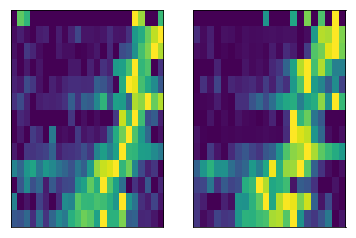

In [69]:
plt.subplot(121)
plt.imshow(scalezscore(znfdfchis[0].loc[g_somito_human]), aspect = 'auto')
plt.xticks([]); plt.yticks([])

plt.subplot(122)
plt.imshow(scalezscore(znfdfchis[1].loc[g_somito_human]), aspect = 'auto')
plt.xticks([]); plt.yticks([])

plt.savefig('/Users/anna/Dropbox/gastruloids/WritingPapers/code4figures/figSomitogenesis/human-replicates-somito.pdf', bbox_inches = 'tight')
plt.show()

# 3 germ layers

In [70]:
# Naomi's assigment
germlayer_genes = read_csv('../gene_lineages.tsv', sep = '\t')

cnt = Counter(list(znfdfchis[0].index)+list(znfdfchis[1].index))
germlayer_genes['gene name'] = [[idx for idx in cnt if '_' + g.upper() + '_' in idx][0] if len([idx for idx in cnt if '_' + g.upper() + '_' in idx])==1 else '-' for g in germlayer_genes['Gene']]
germlayefr_genes['cnt'] = [cnt[idx] for idx in germlayer_genes['gene name']]

f_germlayer_genes = germlayer_genes.loc[germlayer_genes.index[germlayer_genes['cnt']==2]]

In [71]:
# Alfonso's assigment
germlayer_genes = pd.read_excel('../gene_lineages_v2.xls', sheetname='heatmap_germlayers_v2')
f_germlayer_genes = germlayer_genes.loc[[idx for idx in germlayer_genes.index if germlayer_genes.loc[idx, 'Alfonsos assigment'] in ['Endoderm','Mesoderm','Ectoderm']]]

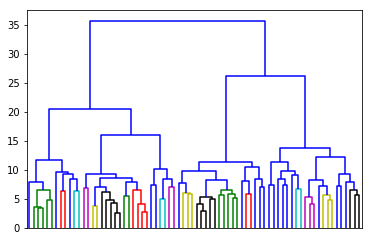

In [72]:
hcl_germlayer = linkage(mznfdfchis.loc[f_germlayer_genes['gene name']], method='ward', metric='euclidean')
dg_germlayer = dendrogram(hcl_germlayer, no_labels=True, color_threshold = 7) # 5
plt.show()
hcl_germlayer = getClusterByColor(dg_germlayer, list(f_germlayer_genes['gene name']))

In [73]:
hcl_germlayer = pd.Series({g: hcl  for hcl in hcl_germlayer for g in hcl_germlayer[hcl]})

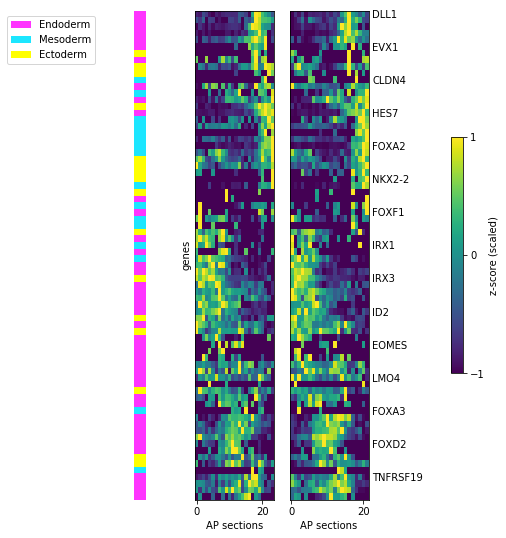

In [74]:
go = hcl_germlayer.sort_values().index

plt.figure(figsize=(6.5,9))
plt.subplot(141, frameon = False)
d = {'Ectoderm': 0, 'Endoderm': 1, 'Mesoderm': 2}
cnt = Counter()
y0 = 0; z0 = 0
for g in go[::-1]:
    y = 1.0/len(go)
#    c = f_germlayer_genes.set_index('gene name').loc[g, 'Lineage']
    c = f_germlayer_genes.set_index('gene name').loc[g, 'Alfonsos assigment']
    cnt.update([c])
    if cnt[c] == 1:
        plt.bar([3], [y], bottom = y0, width = 0.3, color = Colors.colors[d[c]])
    else:
        plt.bar([3], [y], bottom = y0, width = 0.3, color = Colors.colors[d[c]], label='_nolegend_')
    y0 += y 
plt.yticks([]); plt.xticks([])
plt.ylim(0,1)
plt.xlim(2,4)
plt.legend(['Endoderm','Mesoderm','Ectoderm'], loc = 1, bbox_to_anchor = (0,1))

plt.subplot(142)
plt.imshow(scalezscore(znfdfchis[0].loc[go]), aspect = 'auto')
plt.ylabel('genes'); plt.xlabel('AP sections')
plt.yticks([])

plt.subplot(143)
plt.imshow(scalezscore(znfdfchis[1].loc[go]), aspect = 'auto')
plt.tick_params(axis='y', labelleft='off', labelright='on', length = 0)
plt.yticks(range(len(go)), [x.rsplit('_')[1] if np.mod(i,5)==0 else '' for i, x in enumerate(go)])
plt.xlabel('AP sections')

plt.subplot(144, frameon= False)
plt.colorbar(label = 'z-score (scaled)', ticks = [-1,0,1], shrink = 0.5)
plt.xticks([]); plt.yticks([])

#plt.savefig(path + 'heatmap_germlayers_v1.pdf', bbox_inches ='tight')
#pd.Series(go).to_csv(path + 'heatmap_germlayers_v1.txt', sep = '\t')

plt.savefig(path + 'heatmap_germlayers_Alfonsoannotation_v1.pdf', bbox_inches ='tight')
pd.Series(go).to_csv(path + 'heatmap_germlayers_Alfonsoannotation_v1.txt', sep = '\t')

plt.show()

In [75]:
#col = 'Lineage'
col = 'Alfonsos assigment'

hcl_endo = linkage(mznfdfchis.loc[f_germlayer_genes[f_germlayer_genes[col]=='Endoderm']['gene name']], method='ward', metric='euclidean')
hcl_ecto = linkage(mznfdfchis.loc[f_germlayer_genes[f_germlayer_genes[col]=='Ectoderm']['gene name']], method='ward', metric='euclidean')
hcl_meso = linkage(mznfdfchis.loc[f_germlayer_genes[f_germlayer_genes[col]=='Mesoderm']['gene name']], method='ward', metric='euclidean')

dg_endo = dendrogram(hcl_endo, no_labels=True, color_threshold = 7, no_plot=True)
dg_ecto = dendrogram(hcl_ecto, no_labels=True, color_threshold = 7, no_plot=True)
dg_meso = dendrogram(hcl_meso, no_labels=True, color_threshold = 7, no_plot=True)

hcl_endo = getClusterByColor(dg_endo, list(f_germlayer_genes[f_germlayer_genes[col]=='Endoderm']['gene name']))
hcl_ecto = getClusterByColor(dg_ecto, list(f_germlayer_genes[f_germlayer_genes[col]=='Ectoderm']['gene name']))
hcl_meso = getClusterByColor(dg_meso, list(f_germlayer_genes[f_germlayer_genes[col]=='Mesoderm']['gene name']))

hcl_endo = pd.Series({g: hcl  for hcl in hcl_endo for g in hcl_endo[hcl]})
hcl_ecto = pd.Series({g: hcl  for hcl in hcl_ecto for g in hcl_ecto[hcl]})
hcl_meso = pd.Series({g: hcl  for hcl in hcl_meso for g in hcl_meso[hcl]})


In [76]:
f_germlayer_genes.set_index('gene name').loc[g,col]

u'Mesoderm'

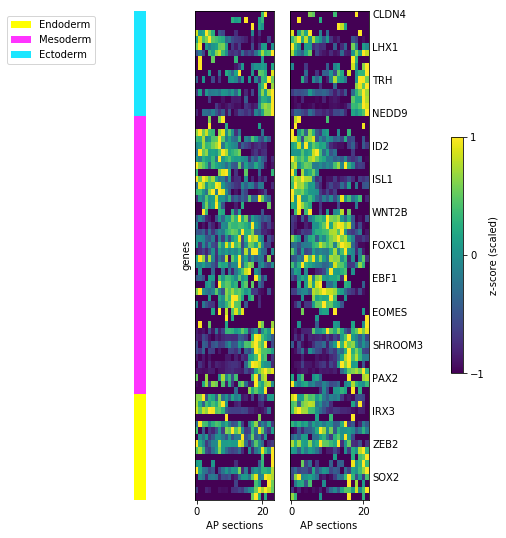

In [77]:
go = list(hcl_endo.sort_values().index)[::-1] + list(hcl_meso.sort_values().index) + list(hcl_ecto.sort_values().index)

plt.figure(figsize=(6.5,9))
plt.subplot(141, frameon = False)
d = {'Ectoderm': 0, 'Endoderm': 1, 'Mesoderm': 2}
cnt = Counter()
y0 = 0; z0 = 0
for g in go[::-1]:
    y = 1.0/len(go)
    c = f_germlayer_genes.set_index('gene name').loc[g, col]
    cnt.update([c])
    if cnt[c] == 1:
        plt.bar([3], [y], bottom = y0, width = 0.3, color = Colors.colors[d[c]])
    else:
        plt.bar([3], [y], bottom = y0, width = 0.3, color = Colors.colors[d[c]], label='_nolegend_')
    y0 += y 
plt.yticks([]); plt.xticks([])
plt.ylim(0,1)
plt.xlim(2,4)
plt.legend(['Endoderm','Mesoderm','Ectoderm'], loc = 1, bbox_to_anchor = (0,1))

plt.subplot(142)
plt.imshow(scalezscore(znfdfchis[0].loc[go]), aspect = 'auto')
plt.ylabel('genes'); plt.xlabel('AP sections')
plt.yticks([])

plt.subplot(143)
plt.imshow(scalezscore(znfdfchis[1].loc[go]), aspect = 'auto')
plt.tick_params(axis='y', labelleft='off', labelright='on', length = 0)
plt.yticks(range(len(go)), [x.rsplit('_')[1] if np.mod(i,5)==0 else '' for i, x in enumerate(go)])
plt.xlabel('AP sections')

plt.subplot(144, frameon= False)
plt.colorbar(label = 'z-score (scaled)', ticks = [-1,0,1], shrink = 0.5)
plt.xticks([]); plt.yticks([])

#plt.savefig(path + 'heatmap_germlayers_v2.pdf', bbox_inches ='tight')
#pd.Series(go).to_csv(path + 'heatmap_germlayers_v2.txt', sep = '\t')

plt.savefig(path + 'heatmap_germlayers_Alfonsoannotation_v2.pdf', bbox_inches ='tight')
pd.Series(go).to_csv(path + 'heatmap_germlayers_Alfonsoannotation_v2.txt', sep = '\t')

plt.show()

In [78]:
path

'/Users/anna/Dropbox/gastruloids/WritingPapers/code4figures/figHuman/'

# Hox genes

Analysis of the HOX gene expression (for each of the clusters A-D and paralogues 1-13, organised as a 4x13 heatmap based on level of expression ie summed across the sections)

In [105]:
def hierarchicalClustering(df, cth = 100, noplot = True):
    Z = linkage(df, method='ward')
    dg = dendrogram(Z, no_labels=True, color_threshold=cth, no_plot = noplot)
    plt.show()
    return Z, dg

In [80]:
hoxgenes_g1 = pd.Series([idx for idx in znfdfchis[0].index if '_HOX' in idx])
hoxgenes_g2 = pd.Series([idx for idx in znfdfchis[1].index if '_HOX' in idx])

In [81]:
letters = ['A','B','C','D']
numbers = range(1,14)

In [82]:
def hoxgene(genes,letter,number):
    g = [x for x in genes if '_HOX' + letter + str(number) + '__' in x]
    if len(g) == 1:
        g = g[0]
    elif len(g) == 0:
        g = ''
    return g

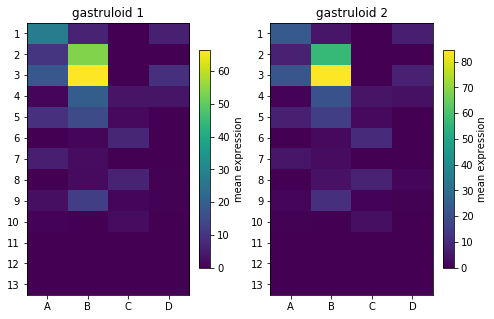

In [84]:
hoxexpr_g1 = pd.DataFrame({l: {n: nfdfchis[0].loc[hoxgene(nfdfchis[0].index, l, n)].mean() if hoxgene(nfdfchis[0].index, l, n) != '' else 0 for n in numbers} for l in letters})
hoxexpr_g2 = pd.DataFrame({l: {n: nfdfchis[1].loc[hoxgene(nfdfchis[1].index, l, n)].mean() if hoxgene(nfdfchis[1].index, l, n) != '' else 0 for n in numbers} for l in letters})

plt.figure(figsize=(8,5))
plt.subplot(121)
plt.imshow(hoxexpr_g1, aspect = 'auto')
plt.yticks(range(len(numbers)), numbers)
plt.xticks(range(len(letters)), letters)
plt.colorbar(label = 'mean expression', shrink = 0.8)
plt.title('gastruloid 1')

plt.subplot(122)
plt.imshow(hoxexpr_g2, aspect = 'auto')
plt.yticks(range(len(numbers)), numbers)
plt.xticks(range(len(letters)), letters)
plt.colorbar(label = 'mean expression', shrink = 0.8)
plt.title('gastruloid 2')

plt.savefig(path + 'HOXmean.pdf', bbox_inches = 'tight')
hoxexpr_g1.to_csv(path + 'HOXmean_g1.tsv', sep = '\t')
hoxexpr_g2.to_csv(path + 'HOXmean_g2.tsv', sep = '\t')
plt.show()

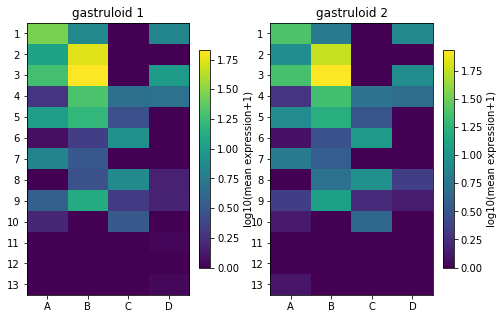

In [85]:
hoxexpr_g1 = pd.DataFrame({l: {n: nfdfchis[0].loc[hoxgene(nfdfchis[0].index, l, n)].mean() if hoxgene(nfdfchis[0].index, l, n) != '' else 0 for n in numbers} for l in letters})
hoxexpr_g2 = pd.DataFrame({l: {n: nfdfchis[1].loc[hoxgene(nfdfchis[1].index, l, n)].mean() if hoxgene(nfdfchis[1].index, l, n) != '' else 0 for n in numbers} for l in letters})

plt.figure(figsize=(8,5))
plt.subplot(121)
plt.imshow(np.log10(hoxexpr_g1+1), aspect = 'auto')
plt.yticks(range(len(numbers)), numbers)
plt.xticks(range(len(letters)), letters)
plt.colorbar(label = 'log10(mean expression+1)', shrink = 0.8)
plt.title('gastruloid 1')

plt.subplot(122)
plt.imshow(np.log10(hoxexpr_g2+1), aspect = 'auto')
plt.yticks(range(len(numbers)), numbers)
plt.xticks(range(len(letters)), letters)
plt.colorbar(label = 'log10(mean expression+1)', shrink = 0.8)
plt.title('gastruloid 2')

plt.savefig(path + 'HOXlogmean.pdf', bbox_inches = 'tight')
hoxexpr_g1.to_csv(path + 'HOXlogmean_g1.tsv', sep = '\t')
hoxexpr_g2.to_csv(path + 'HOXlogmean_g2.tsv', sep = '\t')
plt.show()

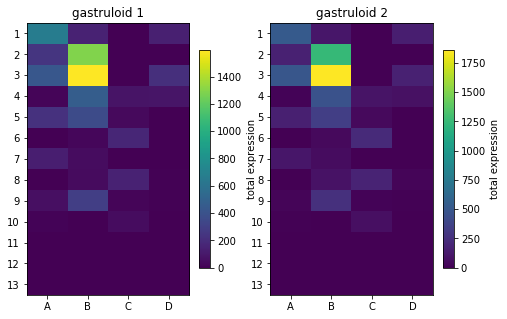

In [86]:
hoxexpr_g1 = pd.DataFrame({l: {n: nfdfchis[0].loc[hoxgene(nfdfchis[0].index, l, n)].sum() if hoxgene(nfdfchis[0].index, l, n) != '' else 0 for n in numbers} for l in letters})
hoxexpr_g2 = pd.DataFrame({l: {n: nfdfchis[1].loc[hoxgene(nfdfchis[1].index, l, n)].sum() if hoxgene(nfdfchis[1].index, l, n) != '' else 0 for n in numbers} for l in letters})

plt.figure(figsize=(8,5))
plt.subplot(121)
plt.imshow(hoxexpr_g1, aspect = 'auto')
plt.yticks(range(len(numbers)), numbers)
plt.xticks(range(len(letters)), letters)
plt.colorbar(label = 'total expression', shrink = 0.8)
plt.title('gastruloid 1')

plt.subplot(122)
plt.imshow(hoxexpr_g2, aspect = 'auto')
plt.yticks(range(len(numbers)), numbers)
plt.xticks(range(len(letters)), letters)
plt.colorbar(label = 'total expression', shrink = 0.8)
plt.title('gastruloid 2')

plt.savefig(path + 'HOXtotal.pdf', bbox_inches = 'tight')
hoxexpr_g1.to_csv(path + 'HOXtotal_g1.tsv', sep = '\t')
hoxexpr_g2.to_csv(path + 'HOXtotal_g2.tsv', sep = '\t')
plt.show()

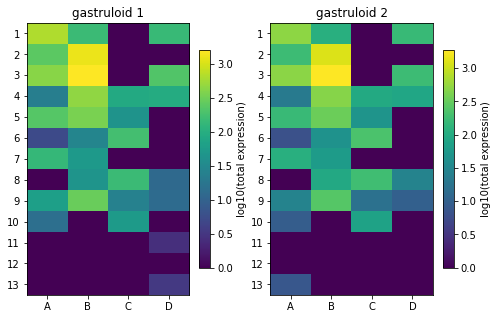

In [87]:
hoxexpr_g1 = pd.DataFrame({l: {n: nfdfchis[0].loc[hoxgene(nfdfchis[0].index, l, n)].sum() if hoxgene(nfdfchis[0].index, l, n) != '' else 0 for n in numbers} for l in letters})
hoxexpr_g2 = pd.DataFrame({l: {n: nfdfchis[1].loc[hoxgene(nfdfchis[1].index, l, n)].sum() if hoxgene(nfdfchis[1].index, l, n) != '' else 0 for n in numbers} for l in letters})

plt.figure(figsize=(8,5))
plt.subplot(121)
plt.imshow(np.log10(hoxexpr_g1+1), aspect = 'auto')
plt.yticks(range(len(numbers)), numbers)
plt.xticks(range(len(letters)), letters)
plt.colorbar(label = 'log10(total expression)', shrink = 0.8)
plt.title('gastruloid 1')

plt.subplot(122)
plt.imshow(np.log10(hoxexpr_g2+1), aspect = 'auto')
plt.yticks(range(len(numbers)), numbers)
plt.xticks(range(len(letters)), letters)
plt.colorbar(label = 'log10(total expression)', shrink = 0.8)
plt.title('gastruloid 2')

plt.savefig(path + 'HOXlogtotal.pdf', bbox_inches = 'tight')
hoxexpr_g1.to_csv(path + 'HOXtotal_g1.tsv', sep = '\t')
hoxexpr_g2.to_csv(path + 'HOXtotal_g2.tsv', sep = '\t')
plt.show()

In [93]:
cnthox = Counter(list(hoxgenes_g1)+list(hoxgenes_g2))
hoxgenes_common = []
for g in cnthox:
    if cnthox[g]==2:
        hoxgenes_common.append(g)

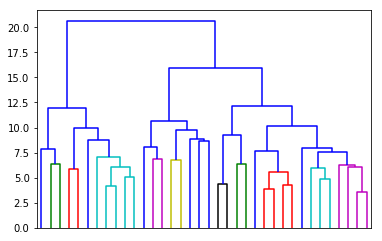

In [119]:
Zhox, dghox = hierarchicalClustering(mznfdfchis.loc[hoxgenes_common], noplot=False, cth = 7.5)
clhox = getClusterByColor(dghox, hoxgenes_common)

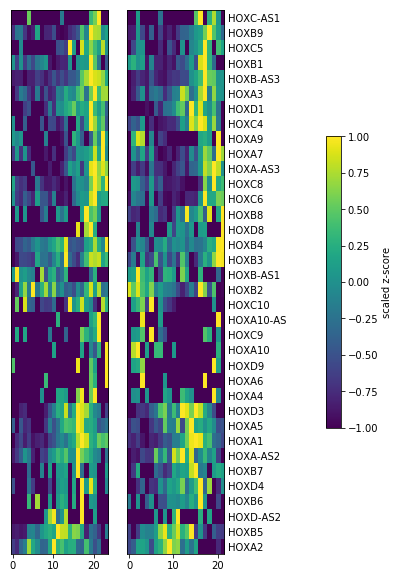

In [120]:
plt.figure(figsize=(8,10))

gene_order = pd.Series({g: i  for i in clhox for g in clhox[i]}).sort_values().index #

for i, df in enumerate(znfdfchis):
    plt.subplot(1,4,i+2)
    plt.imshow(scalezscore(df.loc[gene_order][::-1]), aspect = 'auto')
    plt.yticks([])
plt.tick_params(axis='y', labelleft='off', labelright='on', length = 0)
plt.yticks(range(len(gene_order)), [g.rsplit('__')[0].rsplit('_')[-1] for g in gene_order[::-1]])

plt.subplot(1,4, 4, frameon = False)
plt.xticks([]); plt.yticks([])
plt.colorbar(label = 'scaled z-score')

plt.savefig(path+'/heatmap_Chi_HOXgenes.pdf', bbox_inches = 'tight')
plt.show()

In [121]:
path

'/Users/anna/Dropbox/gastruloids/WritingPapers/code4figures/figHuman/'

# anterior neural genes

In [219]:
braingenes = ['Egr2','Emx1','Emx2', 'En1','En2','Fgf5','Krt5','Krt8','Krt15','Krt18','Tbr1','Wnt1','Six3',
              'Hesx1','Foxg1','Pou3f1','Krox20','Otx1','Otx2','Gbx2','Epha4','Ephb2','Ephb3','Foxb1']

In [220]:
len(braingenes)

24

In [221]:
ortos = read_csv('../../human-mouse-orthologous.txt.gz', sep = '\t')
ortos.head()

,Gene stable ID,Transcript stable ID,Mouse gene stable ID,Mouse gene name,Mouse chromosome/scaffold name,Chromosome/scaffold name,Gene name
0,ENSG00000198888,ENST00000361390,ENSMUSG00000064341,mt-Nd1,MT,MT,MT-ND1
1,ENSG00000198763,ENST00000361453,ENSMUSG00000064345,mt-Nd2,MT,MT,MT-ND2
2,ENSG00000198804,ENST00000361624,ENSMUSG00000064351,mt-Co1,MT,MT,MT-CO1
3,ENSG00000198712,ENST00000361739,ENSMUSG00000064354,mt-Co2,MT,MT,MT-CO2
4,ENSG00000228253,ENST00000361851,ENSMUSG00000064356,mt-Atp8,MT,MT,MT-ATP8


In [222]:
h_braingenes = []
for g in braingenes:
    hg = ortos[ortos['Mouse gene name']==g]['Gene name']
    if len(hg)>0:
        h_braingenes.append(hg.iloc[0])
    else:
        print g
h_braingenes

Krox20


['EGR2',
 'EMX1',
 'EMX2',
 'EN1',
 'EN2',
 'FGF5',
 'KRT5',
 'KRT8',
 'KRT15',
 'KRT18',
 'TBR1',
 'WNT1',
 'SIX3',
 'HESX1',
 'FOXG1',
 'POU3F1',
 'OTX1',
 'OTX2',
 'GBX2',
 'EPHA4',
 'EPHB2',
 'EPHB3',
 'FOXB1']

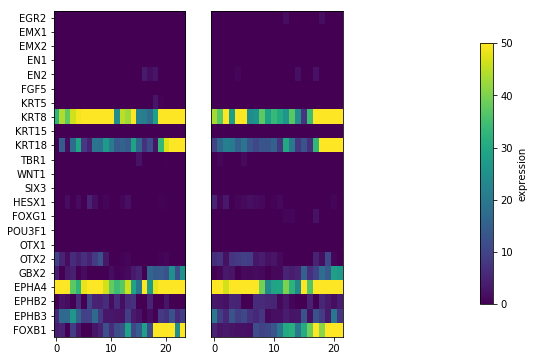

In [223]:
plt.figure(figsize=(8,6))
for i in range(len(nfdfchis)):
    toplot = []
    tolabel = []
    for g in h_braingenes:
        gbo = []
        for idx in nfdfchis[i].index:
            if idx.rsplit('_')[1] == g:
                gbo.append(idx)
        if len(gbo)>0:
            toplot.append(np.array(nfdfchis[i].loc[gbo[0]]))
        else:
            toplot.append(np.array(np.zeros(len(nfdfchis[i].columns))))
    plt.subplot(1, len(nfdfchis)+1,i+1)
    plt.imshow(toplot, aspect = 'auto', vmin = 0, vmax = 50)
    if i == 0:
        plt.yticks(range(len(h_braingenes)), h_braingenes)
    elif i > 0:
        plt.yticks([])

plt.subplot(1, len(nfdfchis)+1,len(nfdfchis)+1, frameon = False)
plt.xticks([]); plt.yticks([])
plt.colorbar(label = 'expression', shrink = 0.8)
        
plt.savefig(path + 'heatmaps_braingenes.pdf', bbox_inches = 'tight')
plt.show()

In [224]:
g.rsplit('_')[0]

'FOXB1'

In [225]:
h_braingenes

['EGR2',
 'EMX1',
 'EMX2',
 'EN1',
 'EN2',
 'FGF5',
 'KRT5',
 'KRT8',
 'KRT15',
 'KRT18',
 'TBR1',
 'WNT1',
 'SIX3',
 'HESX1',
 'FOXG1',
 'POU3F1',
 'OTX1',
 'OTX2',
 'GBX2',
 'EPHA4',
 'EPHB2',
 'EPHB3',
 'FOXB1']